# Modelo de Análisis de Sentimiento en Reseñas en Español

Este notebook presenta el desarrollo de un modelo de **clasificación de sentimiento** aplicado a reseñas y comentarios en español.  
El objetivo es predecir si un texto expresa un sentimiento **positivo**, **negativo** o **neutral**, utilizando un enfoque basado en **machine learning** y probabilidades.

El modelo está diseñado para trabajar con **texto crudo como entrada**, aplicar automáticamente el preprocesamiento necesario y devolver una **etiqueta de sentimiento acompañada de un nivel de certeza**, lo que permite tomar decisiones más informadas en escenarios reales.

Este proyecto está pensado para ser reutilizable en contextos de análisis de opinión de clientes, monitoreo de reseñas o integración en aplicaciones vía inferencia.


## Descripción del dataset

El dataset utilizado contiene reseñas textuales en español asociadas a una etiqueta de sentimiento.  

Cada registro representa un comentario individual emitido por un usuario.

### Características principales:
- **Texto:** comentario o reseña en lenguaje natural.
- **Etiqueta de sentimiento:** variable objetivo utilizada para entrenar el modelo.
- Las clases representan opiniones **positivas** y **negativas**; la categoría **neutral** se introduce posteriormente mediante reglas basadas en probabilidad.

Antes del entrenamiento, los datos han sido revisados para eliminar duplicados y valores nulos relevantes.


In [ ]:
#Cargar dataset

import pandas as pd

data_path = "/content/drive/MyDrive/Oralcle ONE/Hackatón/modelo_prueba8/df_train.csv" #Copiar y pegar la ruta de acceso o subir el archivo de manera local
df = pd.read_csv(data_path, encoding='utf-8', engine='python', doublequote=True)
print(df.shape)
df.head()

(50000, 2)


,comentario,calificacion
0,Uno de los otros críticos ha mencionado que de...,positivo
1,Una pequeña pequeña producción.La técnica de f...,positivo
2,Pensé que esta era una manera maravillosa de p...,positivo
3,"Básicamente, hay una familia donde un niño peq...",negativo
4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


In [ ]:
#Revisar nombre de columnas
df.columns

Index(['comentario', 'calificacion'], dtype='object')

In [ ]:
#Verificar si el tipo de dato por columna y sí hay registros nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comentario    50000 non-null  object
 1   calificacion  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
#Revisar los diferentes valores que hay por fila y la cantidad de ellos (en porcentaje)
df['calificacion'].value_counts(normalize=True)


,proportion
calificacion,
positivo,0.5
negativo,0.5


## Preprocesamiento de texto

El preprocesamiento tiene como objetivo **reducir el ruido lingüístico** del texto y estandarizar su forma antes de ser transformado en variables numéricas.

Las decisiones de limpieza incluyen:
- Conversión a minúsculas para evitar duplicidad semántica.
- Eliminación de acentos para unificar variantes ortográficas.
- Conservación de guiones y underscores cuando aportan significado.
- Normalización de frases frecuentes (por ejemplo, expresiones negativas compuestas) para mejorar la representación semántica.

Este preprocesamiento busca equilibrar simplicidad con conservación del significado original del texto.


In [ ]:

import re
import unicodedata
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# --- DICCIONARIO DE PESOS (Sentiment Scoring) ---
# Escala: +1.5 (Excelente) a -1.5 (Pésimo)
SENTIMENT_WEIGHTS = {
    # POSITIVOS (Fuertes y Moderados)
    "excelente": 1.5, "perfecto": 1.5, "increible": 1.4, "fantastico": 1.4, "maravilloso": 1.4,
    "totalmente_recomendado": 1.5, "recomiendo_totalmente": 1.5, "supero_expectativas": 1.5,
    "muy_satisfecho": 1.3, "todo_perfecto": 1.5,  "mejor": 0.7,
    "recomiendo": 0.8, "genial": 0.9, "gusto": 0.6, "bonito": 0.7, "util": 0.7,
    "recomendable": 0.8, "funciona_bien": 0.9, "buen_producto": 0.8, "vale_la_pena": 1.0,
    "cinco_estrellas": 1.3,  "comodo": 0.7, "rapido": 0.6,"muy_bueno": 0.8,
    "muy_buena": 0.8,
    "es_bueno": 0.5,
    "es_buena": 0.5,
    "realmente_buena": 0.9,
    "realmente_bueno": 0.9,
    "muy_bien": 0.6,
    "realmente_bien": 0.9,

    # NEGATIVOS (Fuertes y Moderados)
    "pesimo": -1.5, "pesimos": -1.5, "horrible": -1.5, "terrible": -1.5, "estafa": -1.5, "fraude": -1.5,
    "no_sirve": -1.4, "peor": -1.3, "basura": -1.4, "desastre": -1.3, "no_recomiendo": -1.3,
    "perdida_dinero": -1.4, "problema": -0.6, "mal": -0.7, "roto": -1.0,
    "mala": -0.7, "caro": -0.6, "mala_calidad": -0.9, "decepcion": -1.0, "no_funciona": -1.1,
    "defectuoso": -1.0, "fallas": -0.8, "producto_danado": -1.2, "llego_tarde": -0.7, "no_volveria": -1.1, "no_gusto": -1.1, "no la recomiendo": -1.5, "no_recomendaria": -1.5,
    "no lo recomiendo": -1.5,

    # NEUTRALES/DEBILES
    "regular": 0.0, "promedio": 0.0, "aceptable": 0.1, "normal": 0.0, "parece": 0.0,
    "correcto": 0.1, "sirve": 0.1, "uso": 0.0, "funcional": 0.1, "esperaba_mas": -0.3,
    "nada_especial": -0.2, "ni_bueno_ni_malo": 0.0, "pasable": 0.0, "ok": 0.1, "bien": 0.0, "buena": 0.0, "bueno": 0.0, "original": 0.0
    }

#Crear función para normailzar textos

stop_words = set(stopwords.words('spanish'))

def normalize_phrases(text):
    replacements = {
        "no lo recomiendo": "no_recomiendo", "no recomiendo": "no_recomiendo",
        "muy buena": "muy_buena","muy bueno": "muy_bueno",
        "es buena": "es_buena",
        "es bueno": "es_bueno",
        "realmente bueno": "realmente_bueno",
        "realmente buena": "realmente_buena",
        "muy bien": "muy_bien",
        "realmente bien": "realmente_bien",
        "buen producto": "buen_producto",
        "excelente calidad": "calidad_excelente", "vale la pena": "vale_la_pena",
        "no funciona": "no_funciona", "no sirve": "no_sirve", "llego tarde": "llego_tarde",
        "llego roto": "producto_danado", "esperaba mas": "esperaba_mas",
        "ni bueno ni malo": "ni_bueno_ni_malo", "no volveria": "no_volveria", "no me gustó": "no_gusto",
        "no me gusto": "no_gusto", "no la recomiendo": "no_recomiendo", "no recomendaria": "no_recomendaria",
        "no lo recomiendo": "no_recomiendo"
    }

    for k, v in replacements.items():
        text = text.replace(k, v)
    return text


#Crear funcion para limpiar el texto
def preprocess_text(text):
    text = text.lower()  #Convierte el texto a minusculas
    text = unicodedata.normalize('NFD', text) #Eliminar acentos
    text = ''.join(c for c in text if unicodedata.category(c) != 'Mn')
    text = re.sub(r'\d+', '', text)  #Remueve numeros
    text = normalize_phrases(text)
    text = re.sub(r'[^\w\s_]', '', text)  #Remueve puntuacion
    text = re.sub(r'\s+', ' ', text)  #Remueve espacios extra

    custom_stopwords = stop_words.union({"simplemente", "tambien", "minutos", "supone","dvd", "gran",
                                         "y", "en", "de", "para", "con", "el", "la", "los", "las", "un", "una",
                                         "definitivamente", "hoy", "siempre", "especialmente", "siquiera", "pobre", "menos", "dinero", "guion",
                                          "creo", "actuaciones", "perfectamente", "corazon","intento", "absoluto", "parece"})

    words = text.split()
    # Mantenemos palabras si están en el diccionario de pesos O si no son stopwords
    cleaned = [w for w in words if w in SENTIMENT_WEIGHTS or (w not in custom_stopwords and len(w) > 2)]
    return " ".join(cleaned)

#Crear función para aplicar la normalización a todo el dataframe
def clean_text_df(df):
    df = df.copy()
    df["comentario"] = df["comentario"].apply(preprocess_text) # Se asume que la columna de texto se llama 'comentario'

    return df

df = clean_text_df(df)
df.head()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,comentario,calificacion
0,criticos mencionado despues ver solo episodio ...,1
1,pequena pequena produccionla tecnica filmacion...,1
2,pense manera maravillosa pasar tiempo fin sema...,1
3,basicamente familia nino pequeno jake piensa z...,0
4,amor tiempo petter mattei pelicula visualmente...,1


In [ ]:
#Convertir la calificacion en etiquetas numericas (positivo = 1, negativo = 0)

df['calificacion'] = df['calificacion'].map({'positivo': 1, 'negativo': 0}) # Este dataset contiene únicamente clases positivo y negativo
df.sample(6)


,comentario,calificacion
43984,esqueletos armario llevan padreteenage fee nue...,0
4233,pelicula descuidadamente escritapobre caracter...,0
21967,peliculas novia momento puedo decir mejor mome...,1
26073,juego caballero usa juego golf entorno club ca...,0
11101,fan estilo extrano jess franco amante incluso ...,0
10774,leido cada libros pimpernel scarlet baroness o...,0


## Arquitectura del modelo y pipeline

El modelo se construye utilizando un **pipeline**, lo que permite encapsular todo el flujo de transformación y predicción en una sola estructura.

El pipeline incluye:
- Vectorización del texto mediante técnicas de representación numérica.
- Un clasificador entrenado para distinguir entre clases de sentimiento.
- Métodos para obtener tanto la **predicción final** como las **probabilidades asociadas**.

Este enfoque garantiza que el mismo preprocesamiento se aplique de forma consistente tanto en entrenamiento como en inferencia.


In [ ]:


##Separar los datos para entrenamiento (train) y para prueba (test) y validacion (val)

from sklearn.model_selection import train_test_split

# Variables independientes y objetivo
X = df['comentario']     # Series de strings
y = df['calificacion']   # Etiqueta binaria

#Separar conjunto de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

#Separar conjunto de validación desde train (20% total)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,      # 0.25 de 80% = 20% del total
    random_state=42,
    stratify=y_train
)

#Revisar que la cantidad de datos para entrenamiento, validación y prueba estén equilibrados
print("Train:", y_train.value_counts(normalize=True))
print("Val:", y_val.value_counts(normalize=True))
print("Test:", y_test.value_counts(normalize=True))


Train: calificacion
1    0.5
0    0.5
Name: proportion, dtype: float64
Val: calificacion
1    0.5
0    0.5
Name: proportion, dtype: float64
Test: calificacion
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
##Entrenar modelo (pipeline exportable)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(max_iter=1000))
])

#Entrenamiento
pipeline.fit(X_train, y_train)

#Validación
y_val_pred = pipeline.predict(X_val)

#Evaluación
print(f'Accuracy: {accuracy_score(y_val, y_val_pred)}')
print(f'Classification Report:\n{classification_report(y_val, y_val_pred)}')


Accuracy: 0.8766
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      5000
           1       0.86      0.90      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Evaluación del modelo

El desempeño del modelo se evalúa utilizando métricas estándar de clasificación, como:
- Accuracy
- Precision
- Recall
- F1-score

Estas métricas permiten analizar no solo qué tan preciso es el modelo en general, sino también cómo se comporta ante errores de clasificación, lo cual es especialmente importante en tareas de análisis de sentimiento donde los falsos positivos o negativos pueden tener distinto impacto.


In [ ]:

#Evaluación final en TEST

y_test_pred = pipeline.predict(X_test)

print("TEST RESULTS (Final)")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_test_pred)}")


TEST RESULTS (Final)
Accuracy: 0.8766
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      5000
           1       0.86      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



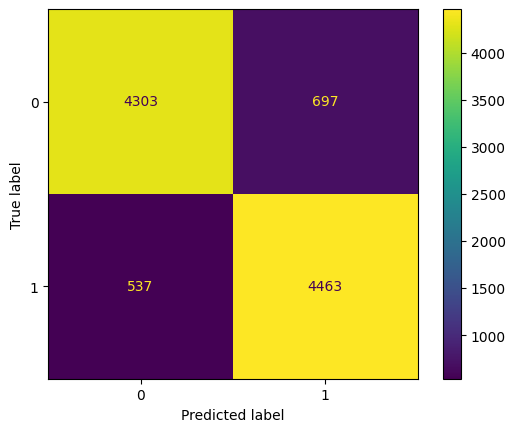

In [ ]:
#Crear y visualizar matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

In [ ]:
#Calcular el ROC-AUC: mide qué tan bien el modelo distingue la clase positiva usando probabilidades (no etiquetas)

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1])

np.float64(0.94697964)

#Exportar el pipeline

El pipeline se exporta en formato ```.pkl``` para que pueda utilizarse en un notebook de inferencia, es decir, en un notebook que sirva exclusivamente para probar el modelo. Sin embargo, para mantener toda la explicación y documentación en un solo documento, después de la exportación siguen los bloques de código que se podrían implementar en ese segundo modelo, que consiste basicamente en crear umbrales para el manejo los comentarios neutrales.

También se exporta en formato ```.onnx``` para que el equipo de backend pueda trabajar con él en Java.

Además, se realizó una prueba de ambas versiones del pipeline para veririfcar que se comporten de manera similae.

In [ ]:
import joblib

joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

In [ ]:
#Verificar el tipo del objeto pipeline (confirma que es un sklearn Pipeline)

type(pipeline)


sklearn.pipeline.Pipeline

In [ ]:
#Mostrar los pasos del pipeline en orden (preprocesamiento y modelo)

pipeline.steps


[('tfidf',
  TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2), sublinear_tf=True)),
 ('clf', LogisticRegression(max_iter=1000))]

In [ ]:
#Instalar librerías para convertir y ejecutar modelos de scikit-learn en formato ONNX

!pip install skl2onnx onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.6 MB/s eta 0:00:00


In [ ]:
# Convertir el pipeline de scikit-learn a ONNX definiendo entrada de texto y guardar el modelo exportado
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

#Definir el tipo de entrada:
  # - batch de strings
  # - forma [None, 1] porque ONNX espera 2D
initial_type = [('input_text', StringTensorType([None, 1]))]

onnx_model = convert_sklearn(
    pipeline,
    initial_types=initial_type,
    target_opset=12  # estable y compatible
)

#Guardar el modelo ONNX
with open("pipeline.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())


In [ ]:
#Cargar el modelo ONNX y muestra los nombres de sus entradas y salidas para usar en inferencia

import onnxruntime as ort
import numpy as np

# Cargar modelo ONNX
session = ort.InferenceSession("pipeline.onnx", providers=["CPUExecutionProvider"])

# Ver nombres de entrada y salida
print("Inputs:", [i.name for i in session.get_inputs()])
print("Outputs:", [o.name for o in session.get_outputs()])


Inputs: ['input_text']
Outputs: ['output_label', 'output_probability']


In [ ]:
#Ejecutar inferencia ONNX con texto limpio, preparando la entrada 2D y obteniendo etiquetas y probabilidades

text = ["el producto es decepcionante"] # Texto YA LIMPIO (importante)

# ONNX espera array 2D
inputs = {
    session.get_inputs()[0].name: np.array(text).reshape(-1, 1)
}

outputs = session.run(None, inputs)

# Normalmente:
  # outputs[0] → etiquetas
  # outputs[1] → probabilidades
#Pero en este caso:
  # outputs[0] → porbabilidad de negativo
  # outputs[1] → probabilidad de positivo

print(outputs)


[array([0], dtype=int64), [{0: 0.9068804979324341, 1: 0.09311947226524353}]]


In [ ]:
#Devuelve las probabilidades por clase del modelo usando todo el pipeline (.pkl)

pipeline.predict_proba(text) #El modelo debe devolver resultados similares al que se exporto en formato .onnx


array([[0.9068805, 0.0931195]])

## Interpretación de la probabilidad del modelo

Además de la etiqueta de sentimiento, el modelo produce una **probabilidad asociada a la clase positiva**.

Esta probabilidad representa el nivel de certeza del modelo respecto a su predicción.

En lugar de tomar la salida del modelo como una verdad absoluta, se utiliza esta probabilidad para:
- Identificar predicciones con alta certeza.
- Marcar como **neutros** aquellos casos donde el modelo muestra una confianza que ocila entre 31% y 69%.
- Ese nivel de confianza (probabilidad) se obtiene después de haber ajustado la probabilidad del modelo mediante el uso del diccionario de pesos.

Este enfoque reduce decisiones forzadas y mejora la utilidad del modelo en escenarios reales.


## Función final de predicción

La siguiente función representa la **interfaz principal del modelo** y es la que se utilizaría en un entorno de producción o integración externa.

### Características:
- Recibe texto crudo como entrada.
- Aplica automáticamente el preprocesamiento necesario mediante el pipeline.
- Devuelve una etiqueta de sentimiento y una probabilidad de certeza.
- Implementa reglas de decisión para identificar casos neutros.

Esta función encapsula toda la lógica necesaria para realizar inferencia de forma consistente.


In [ ]:
#Crear función para ajustar probabilidades
  # Ajusta la probabilidad positiva usando pesos semánticos.alpha controla qué tanto influyen las reglas (0–0.3 recomendable).

def adjust_probability(text, prob_pos, alpha=0.15):

    words = text.split()
    score = 0

    for w in words:
        if w in SENTIMENT_WEIGHTS:
            score += SENTIMENT_WEIGHTS[w]

    # normalizamos el score para que no explote
    score = max(min(score, 2), -2)

    # ajuste suave
    adjusted_prob = prob_pos + alpha * score

    # clamp final
    adjusted_prob = max(min(adjusted_prob, 0.99), 0.01)

    return adjusted_prob

In [ ]:
#Función final de predicción
def predict_sentiment(text):

    text_clean = preprocess_text(text)

    prob_pos = pipeline.predict_proba([text_clean])[0][1]
    prob_adj = adjust_probability(text_clean, prob_pos)

    if prob_adj >= 0.70:
        label = "Positivo"
    elif prob_adj <= 0.30:
        label = "Negativo"
    else:
        label = "Neutral"

    return {
        "sentimiento": label,
        "prob_original": round(float(prob_pos), 3),
        "prob_ajustada": round(float(prob_adj), 3)
    }

#Probar modelo en nuevas resenas/cometarios
new_review_text = "a mama le gustó, pero a mi no, no la recomiendo porque es aburrida y horrible"
print(f'Comentario/Resena: {new_review_text}')
print(f'Sentimiento: {predict_sentiment(new_review_text)}')

Comentario/Resena: a mama le gustó, pero a mi no, no la recomiendo porque es aburrida y horrible
Sentimiento: {'sentimiento': 'Negativo', 'prob_original': 0.14, 'prob_ajustada': 0.125}


## Limitaciones del modelo

Este modelo presenta algunas limitaciones importantes:

- Depende de la calidad y representatividad del dataset de entrenamiento.
- Puede tener dificultades con ironía, sarcasmo o contexto cultural complejo.
- No debe interpretarse como una medida absoluta de opinión, sino como una herramienta de apoyo al análisis.

Estas limitaciones deben considerarse antes de su uso en aplicaciones críticas.


## Próximos pasos

Algunas posibles mejoras futuras incluyen:
- Ajuste fino de los umbrales de probabilidad.
- Ampliación del dataset con más variedad lingüística.
- Integración del modelo en una API o exportación a formatos de inferencia como ONNX.
- Evaluación con datos completamente nuevos para validar generalización.

Estas mejoras permitirían aumentar la robustez y escalabilidad del sistema.


#NOTA:
Para su integración en una API mediante Java, es necesario replicar tanto el diccionario ```SENTIMENT_WEIGHTS``` como las funciones ```adjust_probability() ``` y ```predict_sentiment() ```.

Esto se hizo puede consultarse en el siguiente link: https://drive.google.com/drive/folders/15Wx6KaM8HsG_eqI3OD4adIyJuJ4vtcJR?usp=sharing (leer archivo README).